In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import glob
import lmfit as lm

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [33]:
LCN_study = pd.read_csv("MGH results/LCN_bolus_study_subject_info.csv")
LCN_study = LCN_study.rename(columns={"subject":"sub"})

In [39]:
data = pd.read_csv("MGH results/brain_network_stability_20210416051826.csv")

In [5]:
data_wb = data[data["subnetwork"]=="whole_brain"]
data_wb

,sub,ses,task,run,tau,time,subnetwork,stability
15,6,bhb,rest,1,1,1,whole_brain,0.623454
31,6,bhb,rest,1,1,2,whole_brain,0.566126
47,6,bhb,rest,1,1,3,whole_brain,0.630770
63,6,bhb,rest,1,1,4,whole_brain,0.566796
79,6,bhb,rest,1,1,5,whole_brain,0.631703
...,...,...,...,...,...,...,...,...
3583807,95,glc,task,2,23,19,whole_brain,NaN
3583823,95,glc,task,2,23,20,whole_brain,NaN
3583839,95,glc,task,2,23,21,whole_brain,NaN
3583855,95,glc,task,2,23,22,whole_brain,NaN


In [234]:
def calc_instabilities(data,ses,task,run,subnetwork):
    data_sel = data[np.logical_and(data["subnetwork"]==subnetwork,data_wb["run"]==run)]
    data_sel = data_sel[np.logical_and(data_sel["task"]==task,data_sel["ses"]==ses)]
    data_sel_mean = data_sel[["sub","stability"]].groupby("sub").mean().reset_index()
    data_sel_std = data_sel[["sub","stability"]].groupby("sub").std().reset_index()
    data_sel_mean["std"] = data_sel_std["stability"]/np.sqrt(23)
    return data_sel_mean

def binning(data,bins):
    bins2 = pd.IntervalIndex.from_tuples(bins)
    data_tmp = data.copy()
    data_tmp["age_group"] = pd.cut(data_tmp["age"],bins2)
    data_tmp["variance"] = data_tmp["std"]**2
    data_tmp_mean = data_tmp[["age_group","stability","variance","age"]].groupby("age_group").mean().reset_index()
    data_tmp_std = data_tmp[["age_group","stability","variance"]].groupby("age_group").std().reset_index()
    data_tmp_count = data_tmp[["age_group","age"]].groupby("age_group").count().reset_index()
    data_tmp_mean["std"] = data_tmp_std["stability"]/np.sqrt(data_tmp_count["age"])
    data_tmp_mean["count"] = data_tmp_count["age"]
    return data_tmp_mean

In [12]:
data_bhb_rest = data_wb[np.logical_and(data_wb["task"]=="rest",data_wb["ses"]=="bhb")]
data_glc_rest = data_wb[np.logical_and(data_wb["task"]=="rest",data_wb["ses"]=="bhb")]

In [14]:
data_bhb_run1 = data_wb[data_wb["run"]==1]
data_bhb_run2 = data_wb[data_wb["run"]==2]
data_bhb_run1

,sub,ses,task,run,tau,time,subnetwork,stability
15,6,bhb,rest,1,1,1,whole_brain,0.623454
31,6,bhb,rest,1,1,2,whole_brain,0.566126
47,6,bhb,rest,1,1,3,whole_brain,0.630770
63,6,bhb,rest,1,1,4,whole_brain,0.566796
79,6,bhb,rest,1,1,5,whole_brain,0.631703
...,...,...,...,...,...,...,...,...
3575343,95,glc,task,1,23,19,whole_brain,NaN
3575359,95,glc,task,1,23,20,whole_brain,NaN
3575375,95,glc,task,1,23,21,whole_brain,NaN
3575391,95,glc,task,1,23,22,whole_brain,NaN


In [28]:
data_dhb_run1_mean = data_bhb_run1[["sub","stability"]].groupby("sub").mean().reset_index()
data_dhb_run1_std = data_bhb_run1[["sub","stability"]].groupby("sub").std().reset_index()

<ErrorbarContainer object of 3 artists>

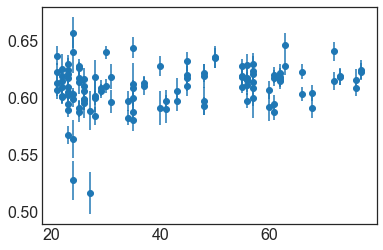

In [69]:
data_sel1b = calc_instabilities(data,"bhb","rest",1,"whole_brain")
data_sel1g = calc_instabilities(data,"glc","rest",1,"whole_brain")
data_sel1bg = pd.concat([data_sel1b,data_sel1g])
data_subnum = pd.merge(data_sel1bg,LCN_study,on="sub")
plt.errorbar(data_subnum["age"],
             y=data_subnum["stability"],
             yerr=data_subnum["std"]/np.sqrt(23),fmt="o")

<ErrorbarContainer object of 3 artists>

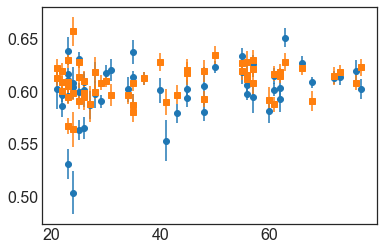

In [67]:
data_sel2b = calc_instabilities(data,"bhb","rest",2,"whole_brain")
data_sel2g = calc_instabilities(data,"glc","rest",2,"whole_brain")
data_2b_sn = pd.merge(data_sel2b,LCN_study,on="sub")
plt.errorbar(data_2b_sn["age"],
             y=data_2b_sn["stability"],
             yerr=data_2b_sn["std"]/np.sqrt(23),fmt="o")
plt.errorbar(data_2b_sn["age"],
             y=data_sel1b["stability"],
             yerr=data_sel1b["std"]/np.sqrt(23),fmt="s")

<ErrorbarContainer object of 3 artists>

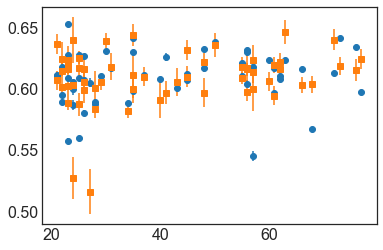

In [231]:
data_sel2b = calc_instabilities(data,"bhb","rest",2,"whole_brain")
data_sel2g = calc_instabilities(data,"glc","rest",2,"whole_brain")
data_2b_sn = pd.merge(data_sel2b,LCN_study,on="sub")
data_2g_sn = pd.merge(data_sel2g,LCN_study,on="sub")
plt.errorbar(data_2g_sn["age"],
             y=data_2g_sn["stability"],
             yerr=data_2g_sn["std"]/np.sqrt(23),fmt="o")
plt.errorbar(data_2b_sn["age"],
             y=data_sel1g["stability"],
             yerr=data_sel1g["std"]/np.sqrt(23),fmt="s")

In [237]:
data_2b_snc = data_2b_sn.drop(labels=[26])
data_2b_snc

,sub,stability,std,age,sex,BMI,bodyweight,HOMA,HbA1c,Matsuda,notes,last_update
0,6,0.613395,0.006353,35,1,24.64,75.1000,0.95,5.4,50.34,using rescreen values,3/22/2021
1,10,0.503916,0.020640,24,1,22.55,70.1000,2.27,5.1,20.02,using rescreen values,NaN
2,11,0.630943,0.006794,25,1,22.59,68.0000,0.24,4.8,27.72,using rescreen values,NaN
3,12,0.601807,0.011752,34,0,23.32,60.6000,1.65,5.5,30.56,NaN,NaN
4,13,0.587349,0.010588,35,1,25.86,72.3000,1.32,5.6,7.41,using rescreen values,NaN
5,15,0.637420,0.011438,35,0,25.06,77.0000,0.91,5.8,8.31,NaN,NaN
6,16,0.617941,0.009589,28,0,26.88,66.0000,2.87,5.2,4.10,NaN,NaN
7,19,0.608046,0.014853,24,1,23.82,74.5000,1.64,5.2,7.63,NaN,NaN
8,20,0.585894,0.009980,22,1,25.03,80.7000,1.18,4.9,10.64,NaN,NaN
9,21,0.610342,0.006787,23,0,23.17,58.4000,2.16,4.7,3.10,NaN,NaN


In [223]:
# lets see what happens when we bin the data
bins = [(i,i+3) for i in range(0,80,5)]
bins

[(0, 3),
 (5, 8),
 (10, 13),
 (15, 18),
 (20, 23),
 (25, 28),
 (30, 33),
 (35, 38),
 (40, 43),
 (45, 48),
 (50, 53),
 (55, 58),
 (60, 63),
 (65, 68),
 (70, 73),
 (75, 78)]

In [104]:
ages = np.arange(22.5,80,5)
ages

array([22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 72.5,
       77.5])

<ErrorbarContainer object of 3 artists>

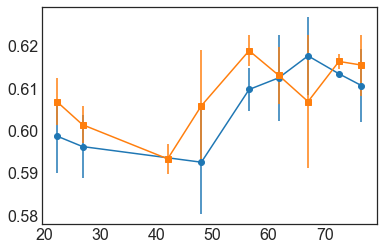

In [239]:
data_1b_sn = pd.merge(data_sel1b,LCN_study,on="sub")
data_2b_sn = pd.merge(data_sel2b,LCN_study,on="sub")
data_1b_bin = binning(data_1b_sn,bins).dropna()
data_2b_bin = binning(data_2b_snc,bins).dropna()

plt.errorbar(data_2b_bin["age"],
             y=data_2b_bin["stability"],
             yerr=data_2b_bin["std"],fmt="o-")
plt.errorbar(data_1b_bin["age"],
             y=data_1b_bin["stability"],
             yerr=data_1b_bin["std"],fmt="s-")

In [236]:
data_2b_bin

,age_group,stability,variance,age,std,count
4,"(20, 23]",0.598708,0.000102,22.300000,0.008783,10
5,"(25, 28]",0.596238,0.000145,26.833333,0.007540,6
8,"(40, 43]",0.566169,0.000235,42.000000,0.012937,2
9,"(45, 48]",0.592542,0.000201,48.000000,0.012328,2
11,"(55, 58]",0.609716,0.000093,56.500000,0.005190,6
12,"(60, 63]",0.612479,0.000080,61.800000,0.010160,5
13,"(65, 68]",0.617659,0.000038,67.000000,0.009235,2
14,"(70, 73]",0.613425,0.000049,72.500000,0.000328,2
15,"(75, 78]",0.610648,0.000104,76.500000,0.008640,2


In [143]:
def sigmoid(x,off,ampl,switchpoint,width):
    return off + ampl/(1+np.exp(-(x-switchpoint)/width))

In [227]:
sigmoid_Model = lm.Model(sigmoid)
pars = sigmoid_Model.make_params()
pars['off'].set(value=0.6,vary=True)
pars['ampl'].set(value=0.1,vary=True)
pars['switchpoint'].set(value=50,vary=True)
pars['width'].set(value=1,vary=True)

out = sigmoid_Model.fit(data_1b_bin["stability"], pars, x=data_1b_bin["age"], weights=1/data_1b_bin["std"],method="leastsq")
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(sigmoid)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 108
    # data points      = 9
    # variables        = 4
    chi-square         = 5.93897054
    reduced chi-square = 1.18779411
    Akaike info crit   = 4.25880108
    Bayesian info crit = 5.04769939
##  Warning: uncertainties could not be estimated:
[[Variables]]
    off:          0.61649330 (init = 0.6)
    ampl:        -0.01789822 (init = 0.1)
    switchpoint:  48.1073461 (init = 50)
    width:       -0.28384412 (init = 1)


In [240]:
pars2 = sigmoid_Model.make_params()
pars2['off'].set(value=0.59,vary=True)
pars2['ampl'].set(value=0.1,vary=True)
pars2['switchpoint'].set(value=50,vary=True)
pars2['width'].set(value=1,vary=True)

out2 = sigmoid_Model.fit(data_2b_bin["stability"], pars2, x=data_2b_bin["age"], weights=1/data_2b_bin["std"],method="leastsq")
print(out2.fit_report(min_correl=0.25))

[[Model]]
    Model(sigmoid)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 8
    # variables        = 4
    chi-square         = 0.48950004
    reduced chi-square = 0.12237501
    Akaike info crit   = -14.3504982
    Bayesian info crit = -14.0327321
[[Variables]]
    off:          0.59644532 +/- 0.00182782 (0.31%) (init = 0.59)
    ampl:         0.01697998 +/- 0.00183183 (10.79%) (init = 0.1)
    switchpoint:  55.4989967 +/- 91.6047581 (165.06%) (init = 50)
    width:        0.78554001 +/- 71.8762814 (9149.92%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(switchpoint, width) = -1.000
    C(off, ampl)          = -0.998


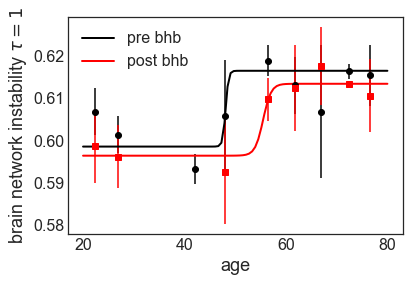

In [266]:
agex = np.linspace(20,80,100)
sig1 = sigmoid_Model.eval(out.params, x=agex)
sig2 = sigmoid_Model.eval(out2.params, x=agex)

plt.errorbar(data_1b_bin["age"],
             y=data_1b_bin["stability"],
             yerr=data_1b_bin["std"],fmt="ok")
plt.plot(agex, sig1, 'k-',linewidth=2,label="pre bhb")
plt.errorbar(data_2b_bin["age"],
             y=data_2b_bin["stability"],
             yerr=data_2b_bin["std"],fmt="sr")
plt.plot(agex, sig2, 'r-',linewidth=2,label="post bhb")
plt.ylabel(r"brain network instability $\tau=1$")
plt.xlabel("age")

plt.legend()

<ErrorbarContainer object of 3 artists>

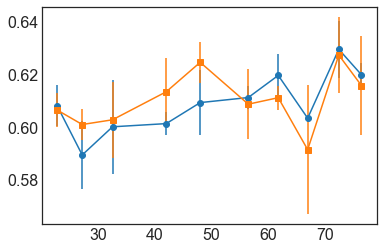

In [264]:
# lets see what happens when we bin the data
binsg = [(i,i+4) for i in range(0,80,5)]
binsdata_1g_sn = pd.merge(data_sel1g,LCN_study,on="sub")
data_2g_sn = pd.merge(data_sel2g,LCN_study,on="sub")
data_1g_bin = binning(data_1g_sn,binsg).dropna()
data_2g_bin = binning(data_2g_sn,binsg).dropna()

plt.errorbar(data_1g_bin["age"],
             y=data_1g_bin["stability"],
             yerr=data_1g_bin["std"],fmt="o-")
plt.errorbar(data_2g_bin["age"],
             y=data_2g_bin["stability"],
             yerr=data_2g_bin["std"],fmt="s-")

In [260]:
pars3 = sigmoid_Model.make_params()
pars3['off'].set(value=0.59,vary=True)
pars3['ampl'].set(value=0.1,vary=True)
pars3['switchpoint'].set(value=55,vary=True)
pars3['width'].set(value=1,vary=True)

out3 = sigmoid_Model.fit(data_2g_bin["stability"],
                         pars3, x=data_2g_bin["age"],
                         weights=1/data_2g_bin["std"],
                         method="leastsq")
print(out3.fit_report(min_correl=0.25))

[[Model]]
    Model(sigmoid)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 88
    # data points      = 9
    # variables        = 4
    chi-square         = 4.95317513
    reduced chi-square = 0.99063503
    Akaike info crit   = 2.62523811
    Bayesian info crit = 3.41413642
[[Variables]]
    off:          0.60365021 +/- 0.00519234 (0.86%) (init = 0.59)
    ampl:         0.01089216 +/- 0.00626827 (57.55%) (init = 0.1)
    switchpoint:  41.6789175 +/- 1.9785e+08 (474697799.93%) (init = 55)
    width:        0.14616810 +/- 90198599.8 (61708813062.42%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(switchpoint, width) = -1.000
    C(off, ampl)          = -0.828


In [258]:
pars4 = sigmoid_Model.make_params()
pars4['off'].set(value=0.59,vary=True)
pars4['ampl'].set(value=0.1,vary=True)
pars4['switchpoint'].set(value=60,vary=True)
pars4['width'].set(value=1,vary=True)

out4 = sigmoid_Model.fit(data_1g_bin["stability"],
                         pars4, x=data_1g_bin["age"],
                         weights=1/data_1g_bin["std"],
                         method="leastsq")
print(out4.fit_report(min_correl=0.25))

[[Model]]
    Model(sigmoid)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 9
    # variables        = 4
    chi-square         = 27.3665401
    reduced chi-square = 5.47330802
    Akaike info crit   = 18.0088687
    Bayesian info crit = 18.7977670
##  Warning: uncertainties could not be estimated:
[[Variables]]
    off:          0.60910926 (init = 0.59)
    ampl:        -0.00562113 (init = 0.1)
    switchpoint:  63.9286087 (init = 60)
    width:        0.07287558 (init = 1)


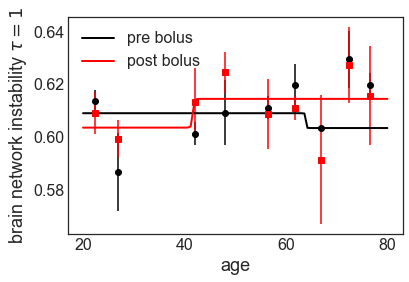

In [261]:
agex = np.linspace(20,80,100)
sig1 = sigmoid_Model.eval(out4.params, x=agex)
sig2 = sigmoid_Model.eval(out3.params, x=agex)

plt.errorbar(data_1g_bin["age"],
             y=data_1g_bin["stability"],
             yerr=data_1g_bin["std"],fmt="ok")
plt.plot(agex, sig1, 'k-',linewidth=2,label="pre bolus")
plt.errorbar(data_2g_bin["age"],
             y=data_2g_bin["stability"],
             yerr=data_2g_bin["std"],fmt="sr")
plt.plot(agex, sig2, 'r-',linewidth=2,label="post bolus")
plt.ylabel(r"brain network instability $\tau=1$")
plt.xlabel("age")

plt.legend()